## EDA and Visualization 

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from IPython.display import Image, display
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import openslide 

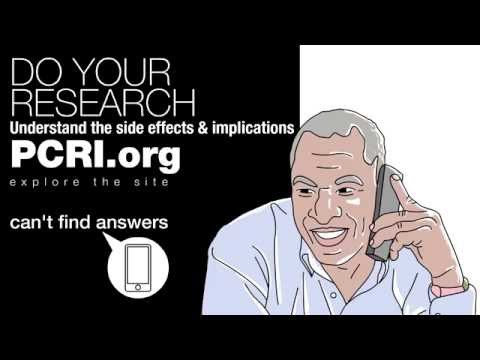

In [2]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('UuG__lpn8qQ',width=600, height=400)

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
# Now that we know everything about ISUP_grade and Gleason_score , 
#let's look at how many unique values they have got, 
#as per our guesses,ISUP must have 6 unique values 
#(1-5 grades and 0 for non cancer) and Gleason_score should have 8 values 
#in total (2-10 for scores)) 

print("unique ids : ", len(train.image_id.unique()))
print("unique data provider : ", len(train.data_provider.unique()))
print("unique isup_grade(target) : ", len(train.isup_grade.unique()))
print("unique gleason_score : ", len(train.gleason_score.unique()))

unique ids :  10616
unique data provider :  2
unique isup_grade(target) :  6
unique gleason_score :  11


In [5]:
train['gleason_score'].unique()

array(['0+0', '4+4', '3+3', '4+3', 'negative', '4+5', '3+4', '5+4', '5+5',
       '5+3', '3+5'], dtype=object)

In [6]:
#SO we can clearly see that our understanding was correct. However I 
#wonder What the label 'Negative' means when we already have 
#0+0 for no cancer. Let's check what is the ISUP grade for these gleason 
#scores

print(train[train['gleason_score']=='0+0']['isup_grade'].unique())
print(train[train['gleason_score']=='negative']['isup_grade'].unique())

[0]
[0]


In [7]:
#That's Quite Interesting , they both map to zero ISUP grade . I
#wonder why there are two labels mapping to the same thing,
#let's also check their number

print(len(train[train['gleason_score']=='0+0']['isup_grade']))
print(len(train[train['gleason_score']=='negative']['isup_grade']))

1925
967


In [8]:
#We have seem from the figure showing mappings of ISUP from 
#gleason that 3+4 and 4+3 map to different ISUP scores 
#while other pairs like 3-5 and 5-3 , 4-5 and 5-4 map to same ISUP, 
#let's verify it

print(train[(train['gleason_score']=='3+4') | (train['gleason_score']=='4+3')]['isup_grade'].unique())
print(train[(train['gleason_score']=='3+5') | (train['gleason_score']=='5+3')]['isup_grade'].unique())
print(train[(train['gleason_score']=='5+4') | (train['gleason_score']=='4+5')]['isup_grade'].unique())



[3 2]
[4]
[5]


In [9]:
#Hence it is indeed the case
#It is due to this reason, modeling this as a predictive problem 
#for gleason score then converting it into ISUP is a much better 
#strategy than to model it as ISUP predictive problem directly

#We can see that 3+4 maps to one unique Isup i.e 2 but to our surprise 
#4+3 maps to two different values , hence we have some mislablled info 
#here, Let's go ahead and check that

train[(train['isup_grade'] == 2) & (train['gleason_score'] == '4+3')]

image_id data_provider  isup_grade gleason_score
7273  b0a92a74cb53899311acc30b7405e101    karolinska           2           4+3

In [10]:
train.drop([7273],inplace=True) 

In [11]:
# Also negative and 0+0 are same labels only from different 
#data-providers and are interchangeable

train['gleason_score'] = train['gleason_score'].apply(lambda x: "0+0" if x=="negative" else x)

In [12]:
temp = train.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [13]:
fig = go.Figure(go.Funnelarea(
    text =temp.isup_grade,
    values = temp.image_id,
    title = {"position": "top center", "text": "Funnel-Chart of ISUP_grade Distribution"}
    ))
fig.show()

In [14]:
fig = px.bar(temp, x='isup_grade', y='image_id',
             hover_data=['image_id', 'isup_grade'], color='image_id',
             labels={'pop':'population of Canada'}, height=400)
fig.show()

We see that the isup_grade 0 and 1 i.e no cancer, has the most number of values and that's what expected in case of most medical datasets , the target class will always be underrepresented and that's also the most important challenge when performing machine learning tasks on Medical DATA

Now let's Look at how much data is provided by which data-provider


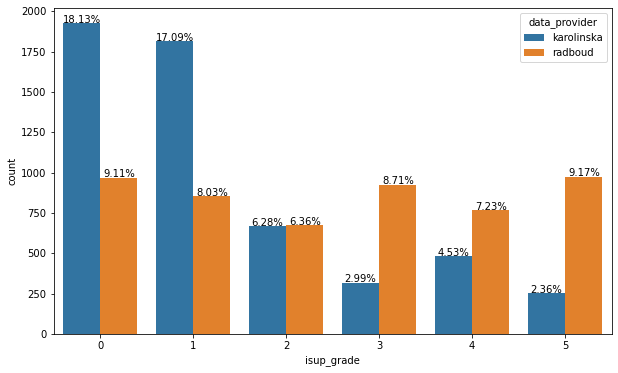

In [15]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
                height +3,
                '{:1.2f}%'.format(100*height/10616),
                ha="center")

In [16]:
# Gleason Score distribution 

temp = train.groupby('gleason_score').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Reds')


### Image EDA

Now we can finally move on to Image EDA . BUT since we are complete beginners, let's first+ understand the format of image that is provided to us and all the image related jargons that we will be using further
Q1) What is .tff format and Why it is used?

Tagged Image File Format (TIFF) is a variable-resolution bitmapped image format developed by Aldus (now part of Adobe) in 1986. TIFF is very common for transporting color or gray-scale images into page layout applications, but is less suited to delivering web content.

Reasons for Usage:

    IFF files are large and of very high quality. Baseline TIFF images are highly portable; most graphics, desktop publishing, and word processing applications understand them.
    The TIFF specification is readily extensible, though this comes at the price of some of its portability. Many applications incorporate their own extensions, but a number of application-independent extensions are recognized by most programs.
    Four types of baseline TIFF images are available: bilevel (black and white), gray scale, palette (i.e., indexed), and RGB (i.e., true color). RGB images may store up to 16.7 million colors. Palette and gray-scale images are limited to 256 colors or shades. A common extension of TIFF also allows for CMYK images.
    TIFF files may or may not be compressed. A number of methods may be used to compress TIFF files, including the Huffman and LZW algorithms. Even compressed, TIFF files are usually much larger than similar GIF or JPEG files.
    Because the files are so large and because there are so many possible variations of each TIFF file type, few web browsers can display them without plug-ins.

Q2) What are image levels?

In some image formats the image data has a fixed amount of possible intensities. For instance an image may be defined as uint8 (unsigned integer 8-bit) which means that each pixel can have a value (intensity) between 0-255, and each intensity is a whole number (integer) in that range. So that gives 256 possible intensity levels. Another way to interpret this would be layers. An RGB (red green blue) type image uses three layers to define colour (a single layer would define a large-scale image, some image types contain more than 3 layers). For each pixel there are 3 intensity levels, 1 for each colour, are defined and together (using a kind of mixing of the colours) they define the colour of that pixels. Similarly for a grayscale there can be two levels i.e black and white
Q3) What is Down-sampling and Up-sampling in Image processing?

Downsampling and upsampling are two fundamental and widely used image operations, with applications in image display, compression, and progressive transmission. Downsampling is the reduction in spatial resolution while keeping the same two-dimensional (2D) representation. It is typically used to reduce the storage and/or transmission requirements of images. Upsampling is the increasing of the spatial resolution while keeping the 2D representation of an image. It is typically used for zooming in on a small region of an image, and for eliminating the pixelation effect that arises when a low-resolution image is displayed on a relatively large frame

Now that we know all this we are good to go.

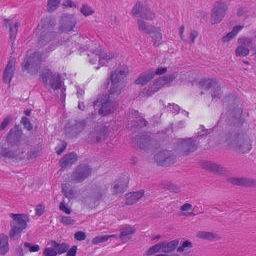

In [17]:
# Open the image (does not yet read the image into memory)
example = openslide.OpenSlide(os.path.join("train_images", '005e66f06bce9c2e49142536caf2f6ee.tiff'))

# Read a specific region of the image starting at upper left coordinate (x=17800, y=19500) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
patch = example.read_region((17800,19500), 0, (256, 256))

# Display the image
display(patch)

# Close the opened slide after use
example.close() 

In [18]:
#This Function prints Zoomed and Non-Zoomed images side by side 
#and also all the information that can be derived from it
#You can read about what every function does in the documentation 
#of Openslide.
#You can play around with the read_region to zoom in different parts 
#of an image and by little modifications you can build a function 
#that takes in multiple images and displays their zoomed and non-Zoomed 
#Images side by side



def get_values(image,max_size=(600,400)):
    slide = openslide.OpenSlide(os.path.join("train_images", f'{image}.tiff'))
    
    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    f,ax =  plt.subplots(2 ,figsize=(6,16))
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    patch = slide.read_region((1780,1950), 0, (256, 256)) #ZOOMED FUGURE
    ax[0].imshow(patch) 
    ax[0].set_title('Zoomed Image')
    
    
    ax[1].imshow(slide.get_thumbnail(size=max_size)) #UNZOOMED FIGURE
    ax[1].set_title('Full Image')
    
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}\n\n")
    
    print(f"ISUP grade: {train.loc[train['image_id'] == image, 'isup_grade']}")
    print(f"Gleason score: {train.loc[train['image_id'] == image, 'gleason_score']}")

File id: OpenSlide('train_images/07a7ef0ba3bb0d6564a73f4f3e1c2293.tiff')
Dimensions: (24900, 29228)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.00457121779945)
Dimensions of levels: ((24900, 29228), (6225, 7307), (1556, 1826))


ISUP grade: 286    4
Name: isup_grade, dtype: int64
Gleason score: 286    4+4
Name: gleason_score, dtype: object


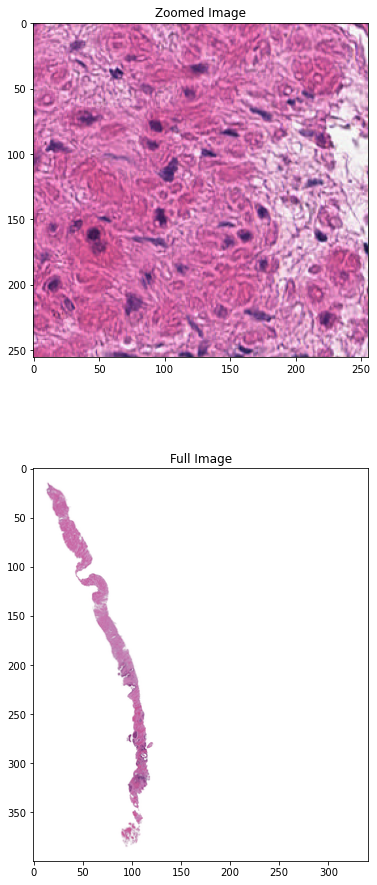

In [19]:
get_values('07a7ef0ba3bb0d6564a73f4f3e1c2293')

Now Let's Look at the Zoomed Images having different ISUP and gleason_score¶

Looking at the images we can see and try to apply what we learned in the video for giving gleason_score

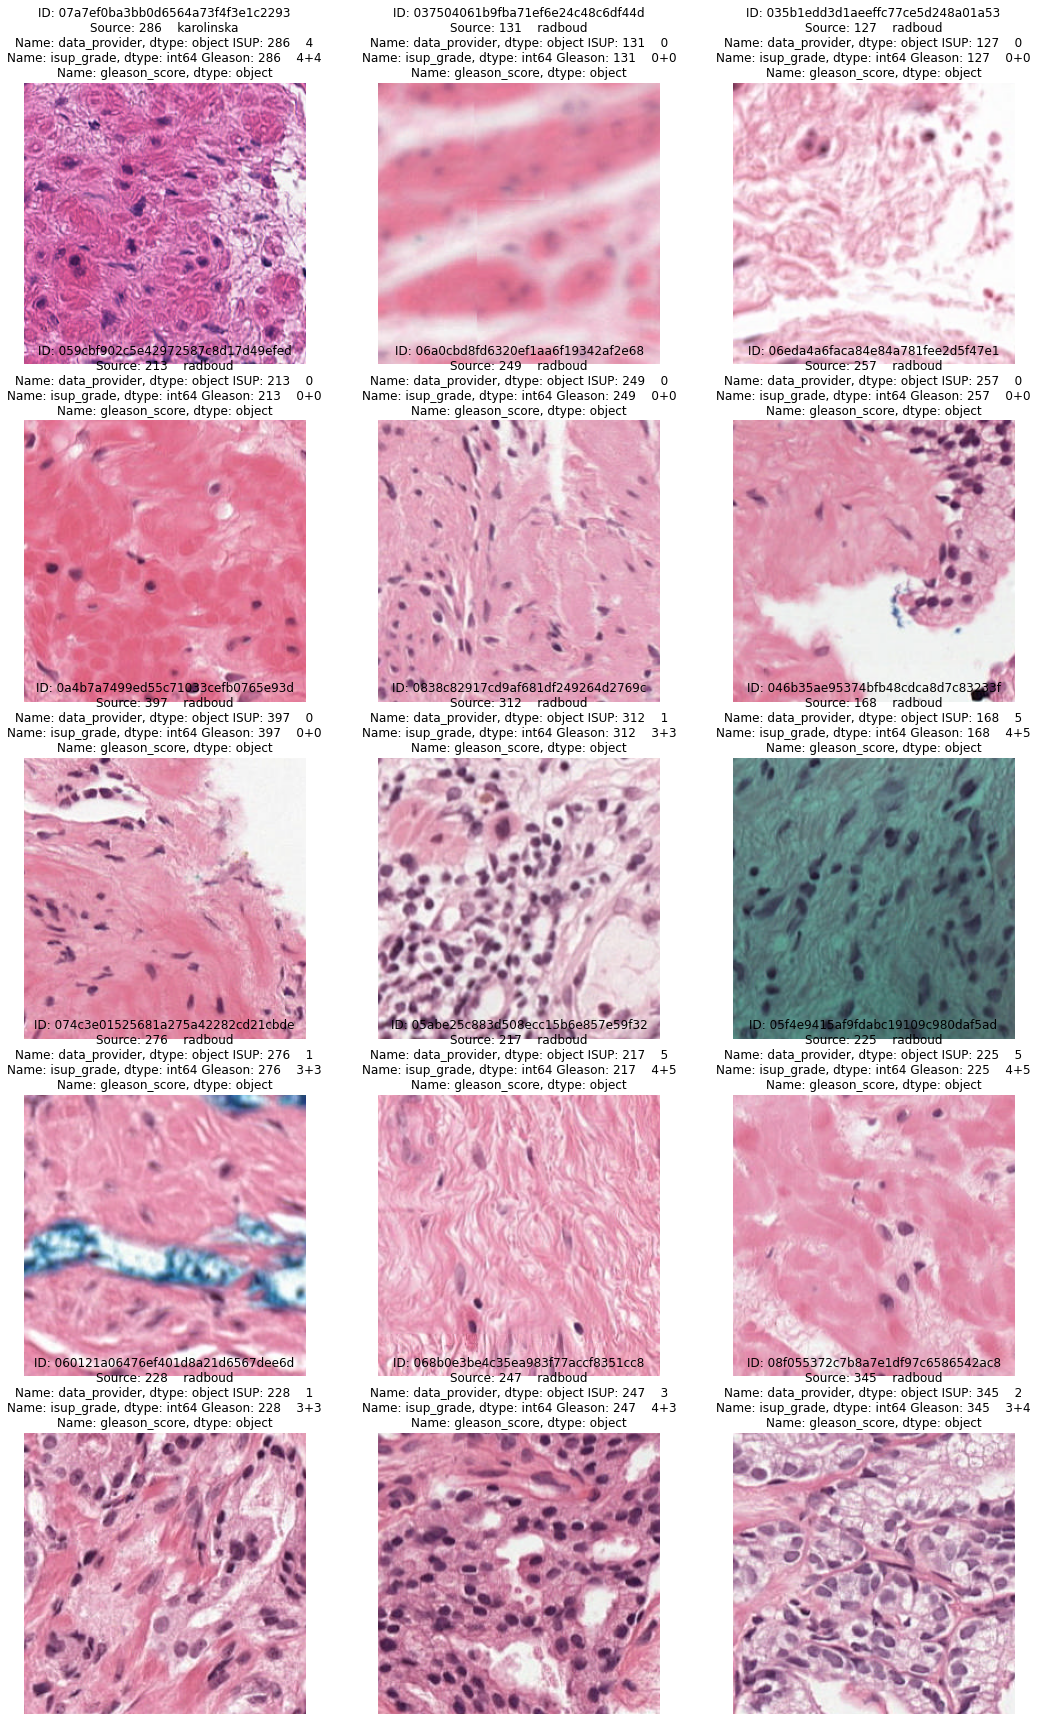

In [20]:
def display_images(images):
    '''
    This function takes in input a list of images. It then iterates 
    through the image making openslide objects, 
    on which different functions
    for getting out information can be called later
    '''
    f, ax = plt.subplots(5,3, figsize=(18,30))
    for i, image in enumerate(images):
        slide = openslide.OpenSlide(os.path.join("train_images", 
                                                 f'{image}.tiff')) 
        # Making Openslide Object
        #Here we compute the "pixel spacing": 
        #the physical size of a pixel in the image,
        #OpenSlide gives the resolution in centimeters so we convert 
        #this to microns
        spacing = 1/(float(slide.properties['tiff.XResolution']) / 10000)
        patch = slide.read_region((1780,1950), 0, (256, 256)) 
        #Reading the image as before betweeen x=1780 to y=1950 and of pixel size =256*256
        ax[i//3, i%3].imshow(patch) #Displaying Image
        slide.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = image
        data_provider = train.loc[train['image_id'] == image, 'data_provider']
        isup_grade = train.loc[train['image_id'] == image, 'isup_grade']
        gleason_score = train.loc[train['image_id'] == image, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 

images = [
'07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]

display_images(images) 

In [21]:
train.head()

image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

OBSERVATIONS:

    The image dimensions are quite large (typically between 5.000 and 40.000 pixels in both x and y).
    Each slide has 3 levels you can load, corresponding to a downsampling of 1, 4 and 16. Intermediate levels can be created by downsampling a higher resolution level.
    The dimensions of each level differ based on the dimensions of the original image.
    Biopsies can be in different rotations. This rotation has no clinical value, and is only dependent on how the biopsy was collected in the lab.
    There are noticable color differences between the biopsies, this is very common within pathology and is caused by different laboratory procedures.




### Understanding Masks

Q) What are masks?

Apart from the slide-level label (present in the csv file), almost all slides in the training set have an associated mask with additional label information. These masks directly indicate which parts of the tissue are healthy and which are cancerous.hese masks are provided to assist with the development of strategies for selecting the most useful subsamples of the images. The mask values depend on the data provider:

    Radboud: Prostate glands are individually labelled, Valid values are:

         0: background (non tissue) or unknown
         1: stroma (connective tissue, non-epithelium tissue)
         2: healthy (benign) epithelium
         3: cancerous epithelium (Gleason 3)
         4: cancerous epithelium (Gleason 4)
         5: cancerous epithelium (Gleason 5)

    Karolinska: Regions are labelled, Valid values are:

            1: background (non tissue) or unknown
            2: benign tissue (stroma and epithelium combined)
            3: cancerous tissue (stroma and epithelium combined)



The label information is stored in the red (R) channel, the other channels are set to zero and can be ignored.

    The masks are not image data like the WSIs.They are just matrices with values based on the data provider information provided above, instead of containing a range of values from 0 to 255, they only go up to a maximum of 6, representing the different class labels (check the dataset description for details on mask labels). Therefor when you try to visualize the mask, it will appear very dark as every value is close to 0. Applying the color map fixes the problem by assigning each label between 0 and 6 a distinct color.

So what we need to do is to grab read the image file using openslide object, take out the values of Red Level and then apply cmap to it

Using a small helper function we can display some basic information about a mask. To more easily inspect the masks, we map the int labels to RGB colors using a color palette. If you prefer something like matplotlib you can also use plt.imshow() to directly show a mask (without converting it to an RGB image).

In [22]:
def display_masks(slides):    
    f, ax = plt.subplots(2,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join('train_label_masks', f'{slide}_mask.tiff'))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[train['image_id'] == slide, 'data_provider']
        isup_grade = train.loc[train['image_id'] == slide, 'isup_grade']
        gleason_score = train.loc[train['image_id'] == slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        f.tight_layout()
        
    plt.show()

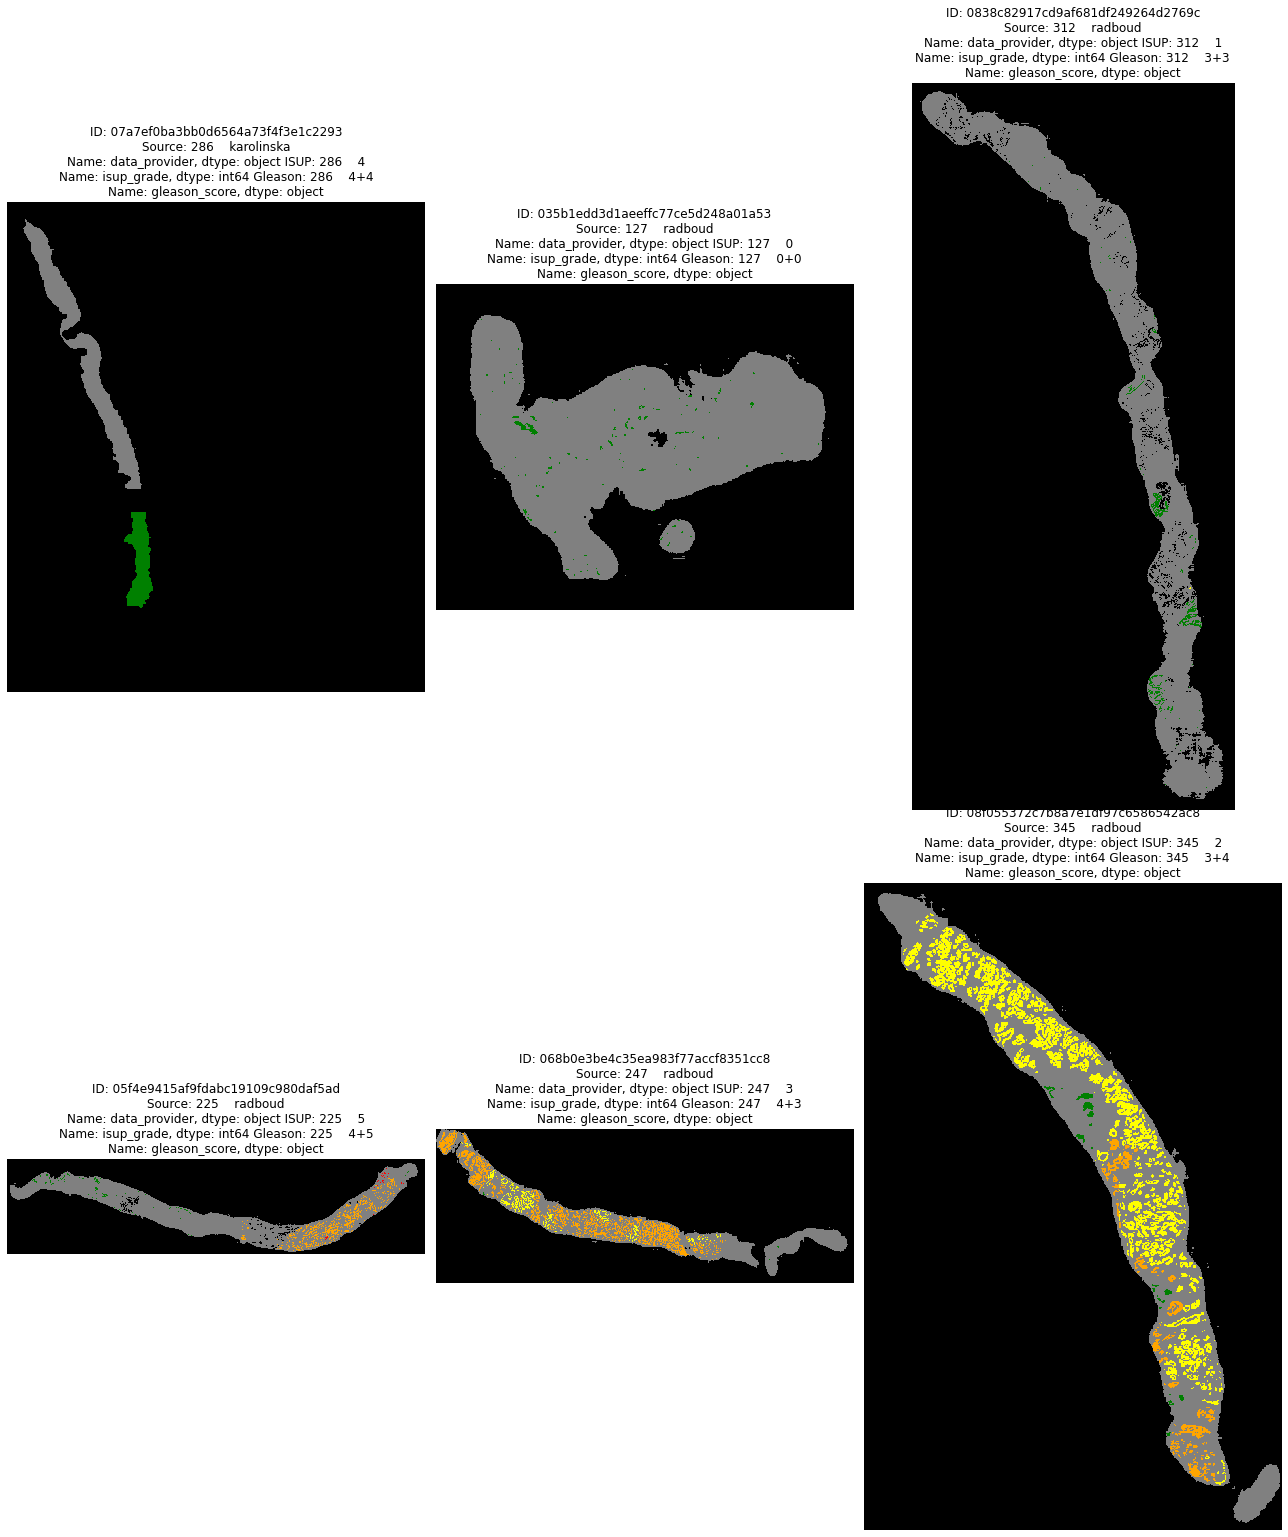

In [23]:
ims = []
idx = [0,2,7,11,13,14]
for i in idx:
    ims.append(images[i])

display_masks(ims)

In [24]:
def mask_img(image,max_size=(600,400)):
    slide = openslide.OpenSlide(os.path.join("train_images", f'{image}.tiff'))
    mask =  openslide.OpenSlide(os.path.join('train_label_masks', f'{image}_mask.tiff'))
    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    f,ax =  plt.subplots(1,2 ,figsize=(18,22))
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    img = slide.get_thumbnail(size=(600,400)) #IMAGE 
    
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    
    ax[0].imshow(img) 
    #ax[0].set_title('Image')
    
    
    ax[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) #IMAGE MASKS
    #ax[1].set_title('Image_MASK')
    
    
    image_id = image
    data_provider = train.loc[train['image_id'] == image, 'data_provider']
    isup_grade = train.loc[train['image_id'] == image, 'isup_grade']
    gleason_score = train.loc[train['image_id'] == image, 'gleason_score']
    ax[0].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE")
    ax[1].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE_MASK")

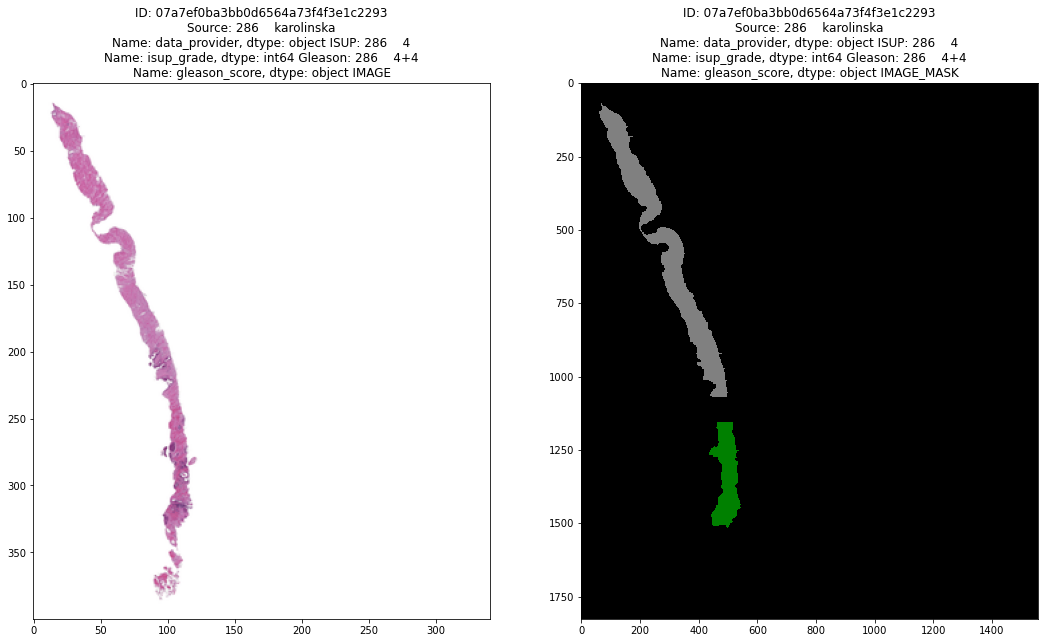

In [25]:
mask_img('07a7ef0ba3bb0d6564a73f4f3e1c2293')

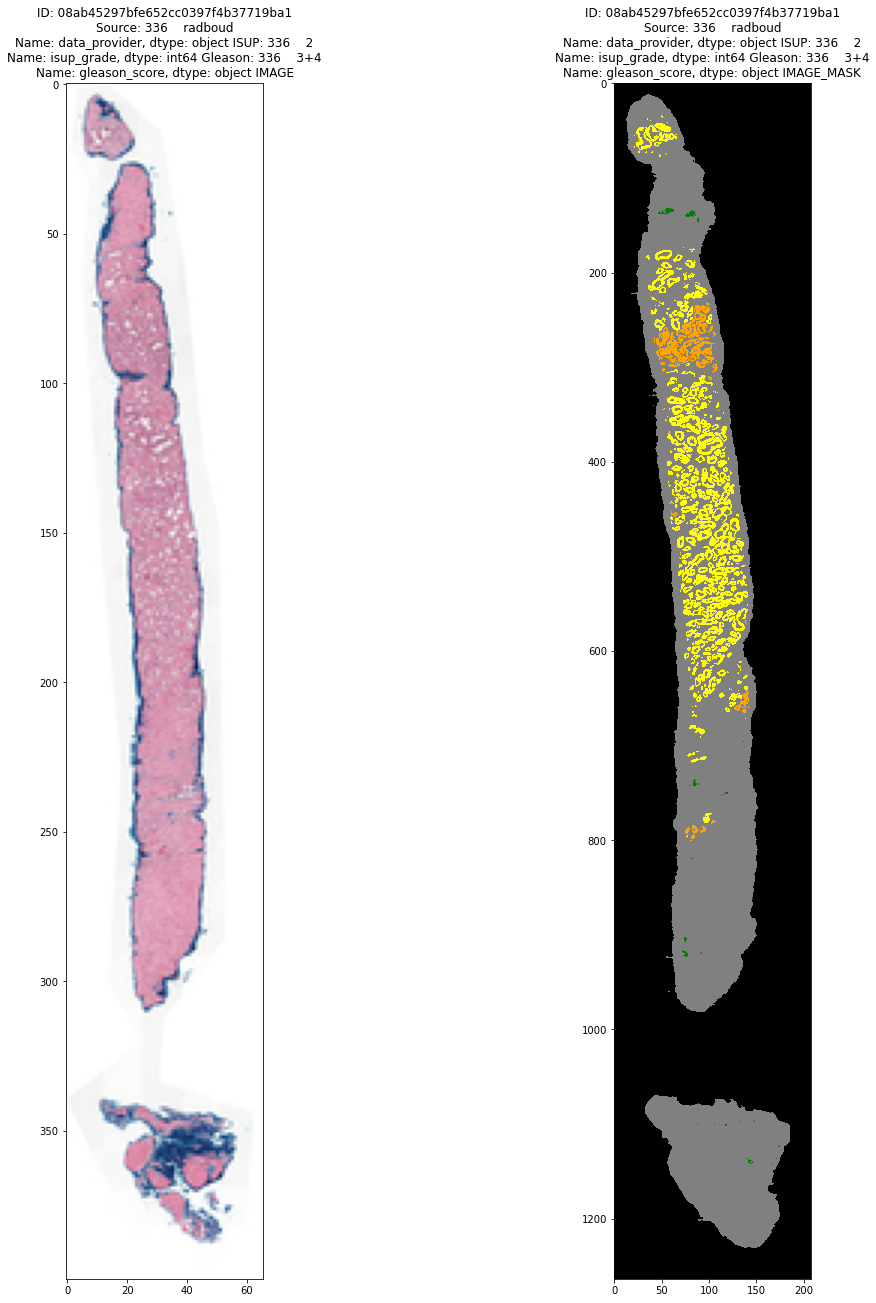

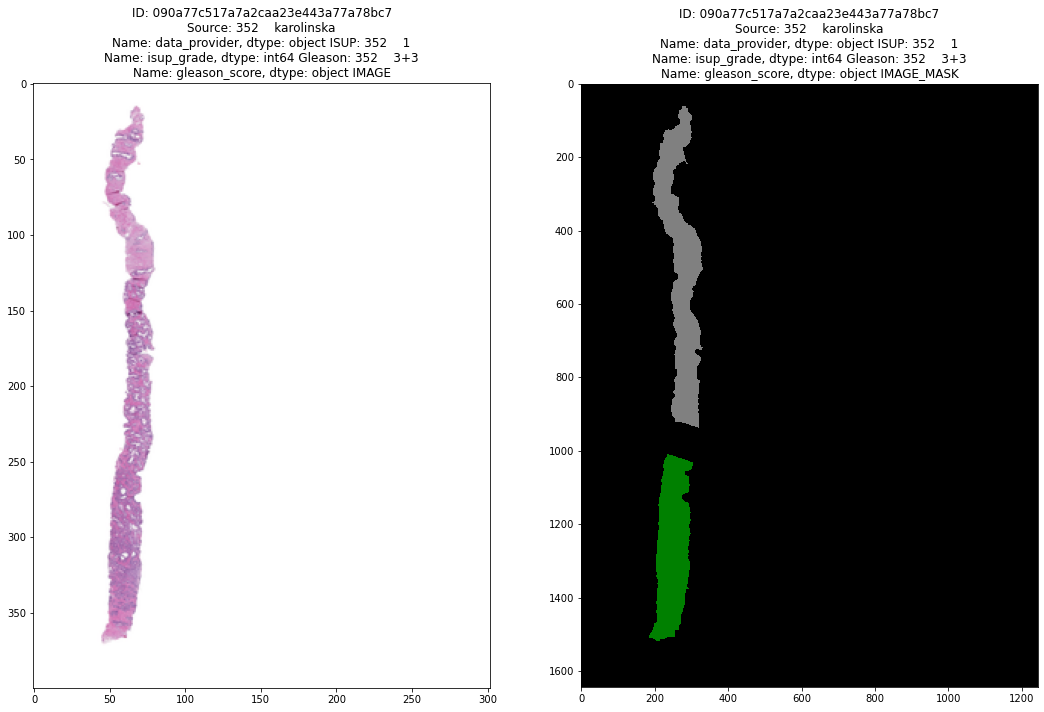

In [26]:
images1= [
    '08ab45297bfe652cc0397f4b37719ba1',
    '090a77c517a7a2caa23e443a77a78bc7'
]

for image in images1:
    mask_img(image)

Observations:

    The images above shows two example masks from the dataset.The first mask is from Radboudumc and shows two different grades of cancer (shown in yellow and orange). The second mask is from Karolinska, the region that contains cancer is higlighted in green.

    Note that in the second example, eventhough a biopsy contains cancer, not all epithelial tissue has to be cancerous.Thus, Biopsies can contain a mix of cancerous and healthy tissue.

### Overlaying masks on the slides

Now That we have learned how to visualize masks and display them side by side , Let's Overlay them on one another

As the masks have the same dimension as the slides, we can overlay the masks on the tissue to directly see which areas are cancerous. This overlay can help you identifying the different growth patterns. To do this, we load both the mask and the biopsy and merge them using PIL.


In [27]:
def overlay_mask_on_slide(images, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    f, ax = plt.subplots(2,3, figsize=(18,22))
    
    
    for i, image_id in enumerate(images):
        slide = openslide.OpenSlide(os.path.join("train_images", f'{image_id}.tiff'))
        mask = openslide.OpenSlide(os.path.join('train_label_masks', f'{image_id}_mask.tiff'))
        slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        mask_data = mask_data.split()[0]
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        data_provider = train.loc[train['image_id']==image_id, 'data_provider']
        isup_grade = train.loc[train['image_id']==image_id, 'isup_grade']
        gleason_score = train.loc[train['image_id']==image_id, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

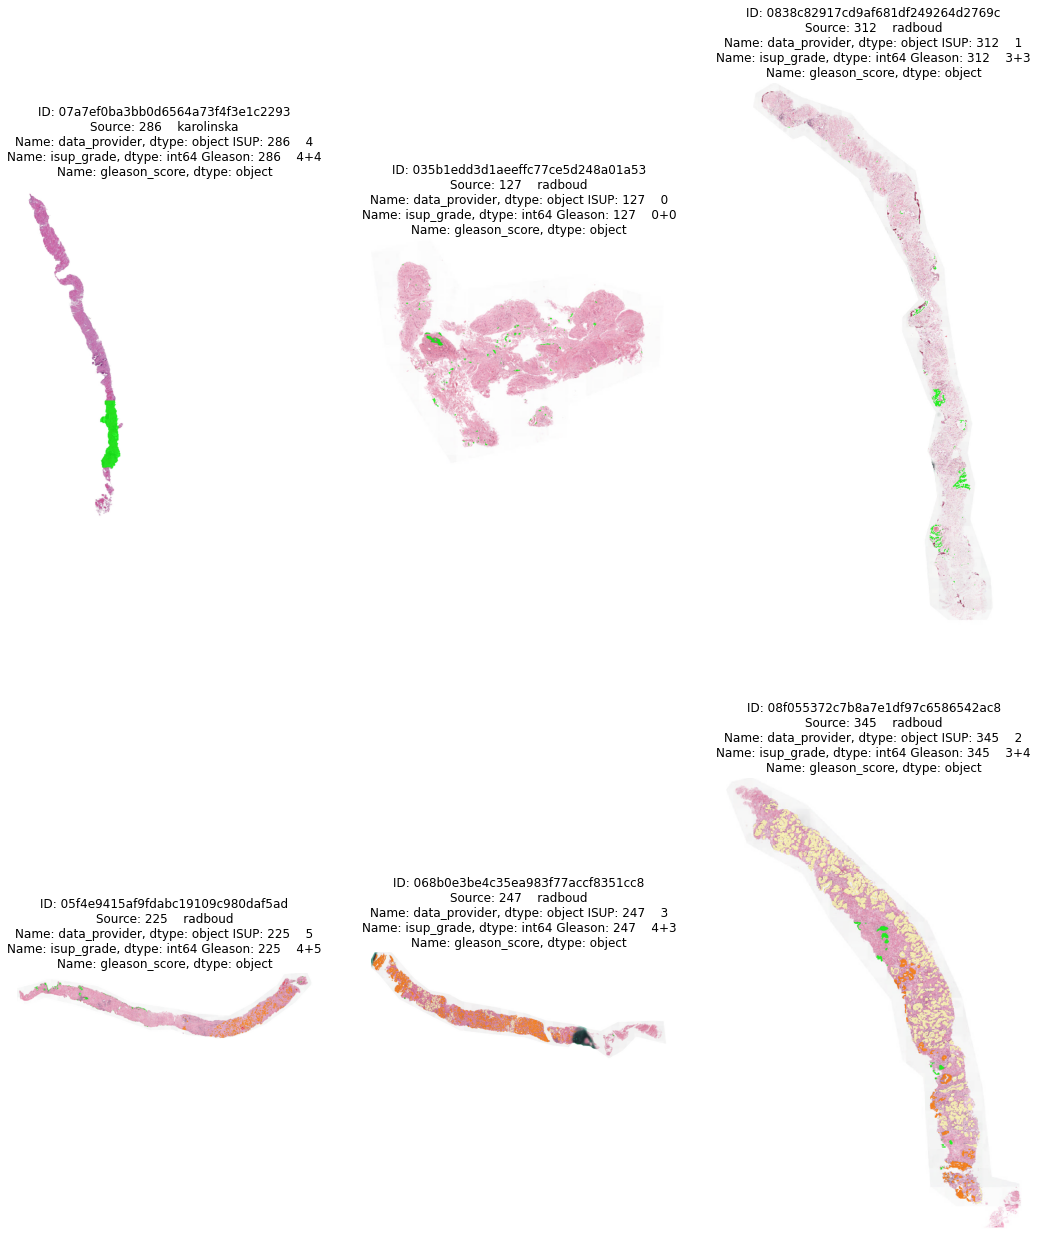

In [28]:
overlay_mask_on_slide(ims)

In [29]:
im = openslide.OpenSlide(os.path.join("train_images", 
                                 '08f055372c7b8a7e1df97c6586542ac8.tiff'))
display(im)

OpenSlide('train_images/08f055372c7b8a7e1df97c6586542ac8.tiff')